<a href="https://colab.research.google.com/github/seovalue/deep-learning-paper-study/blob/master/MNIST_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1, MNIST 데이터셋으로 문자인식해보기

이 notebook을 이용해 아래의 질문들에 대한 해답을 구해보려고 합니다. 

1. activation function이 `sigmoid`일 때와 `relu`일 때는 얼마나 차이가 날까?
2. loss function이 `MSE`일 때와 `CEE`일 때는 얼마나 차이가 날까?

### Activation Function (활성화 함수)

활성화 함수에는 `sigmoid`, `relu`, `tanh` 등이 있습니다.

각 함수의 그래프는 다음과 같습니다.

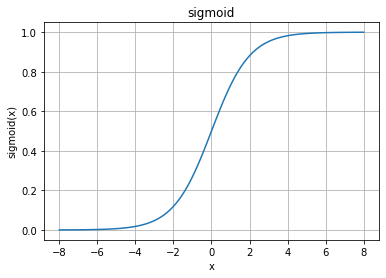

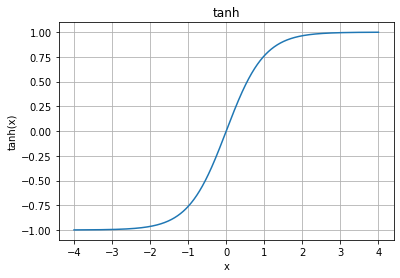

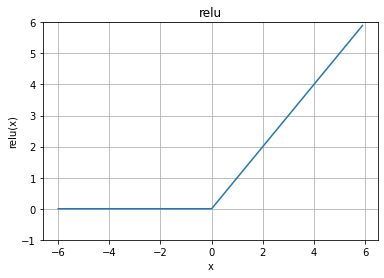

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def sigmo(x):
    a = [] 
    for itr in x: 
        a.append(1/(1+np.exp(-itr))) 
    return a

def relu(x):
   return np.maximum(0, x)

x = np.linspace(-8, 8, 100)
sig = sigmo(x)
plt.title('sigmoid')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.plot(x, sig)
plt.grid()
plt.show() 

x = np.linspace(-4, 4, 1000)
plt.plot(x, np.tanh(x))
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title('tanh')
plt.grid()
plt.show()

x = np.arange(-6.0, 6.0, 0.1)
y = relu(x)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('relu(x)')
plt.title('relu')
plt.grid()
plt.ylim(-1.0, 6)
plt.show()

### Loss Function (손실 함수)

손실함수의 종류인 MSE(Mean Squared Error), CEE(Cross Entropy Error)의 수식은 다음과 같습니다.

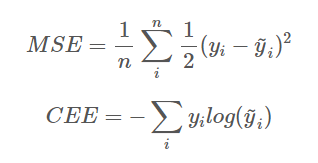

In [37]:
Image('loss.PNG')

In [36]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

from IPython.display import Image

Saving loss.PNG to loss.PNG


필요한 MNIST 데이터셋을 KERAS를 통해 불러옵니다.

In [2]:
mnist = keras.datasets.mnist

In [3]:
(train_images, train_labels),(test_images,test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


훈련 데이터셋과 학습 데이터셋을 분리한 뒤, 제대로 이미지가 읽어들여졌는지 확인합니다.

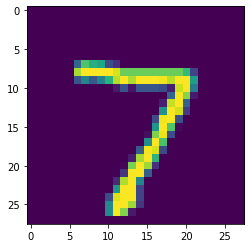

In [4]:
plt.imshow(test_images[0])

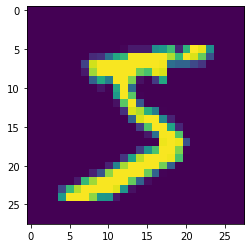

In [5]:
plt.imshow(train_images[0])

이 문제를 해결하기 위해, **Softmax Regression**이라는 방법을 사용할 것입니다.

## Softmax Regression

Softmax Regression은 어떤 input이 주어졌을 때, 그것이 i 라는 클래스에 해당될 것이라고 확신하는 정도인 **evidence**를 아래 수식과 같이 나타냅니다.

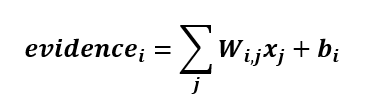

In [6]:
Image('evidence.png')

이 evidence를 softmax Function을 통해 label을 y라고 예측할 확률로 바꾸어줍니다.

위 식에서, softmax 함수 일종의 link 함수로써 선형 함수의 evidence를 원하는 형태로 변경해주는 과정을 거칩니다. 

예를 들자면, 0~9까지의 숫자에 대한 확률 분포와 같습니다.

이 모든 과정을 식으로 나타내면 아래와 같습니다.

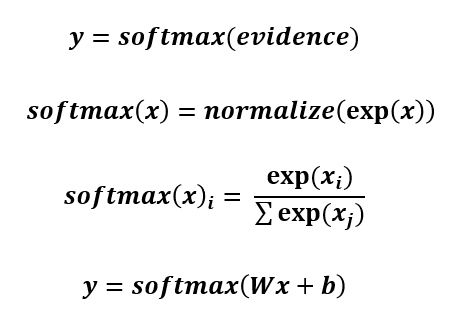

In [7]:
Image('all.png')

In [10]:
cases = [0,1,2,3,4,5,6,7,8,9]

In [11]:
train_images.shape

(60000, 28, 28)

In [12]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

픽셀 값의 범위가 0~255 사이라는 것을 확인할 수 있습니다.

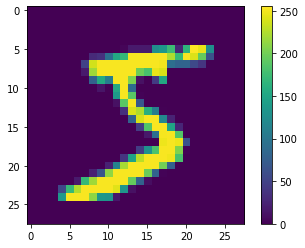

In [13]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 주입하기 전 이 값의 범위를 0~1 사이로 조정하겠습니다. 이 과정을 위해 255로 나누어줍니다. 

훈련 세트와 테스트 세트를 동일한 방식으로 전처리해줘야함에 유의합니다.

In [14]:
train_images = train_images / 255.0

In [15]:
test_images = test_images / 255.0

픽셀 범위가 0~1 사이로 변경된 것을 확인할 수 있습니다.

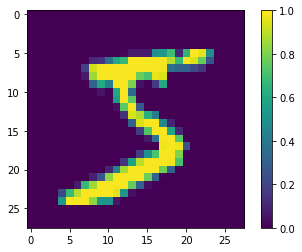

In [16]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

훈련 세트에서 처음 16개의 이미지와 아래 클래스 이름을 출력해봅시다. 데이터 포맷이 올바른지 확인하고 훈련 준비를 마칩니다.

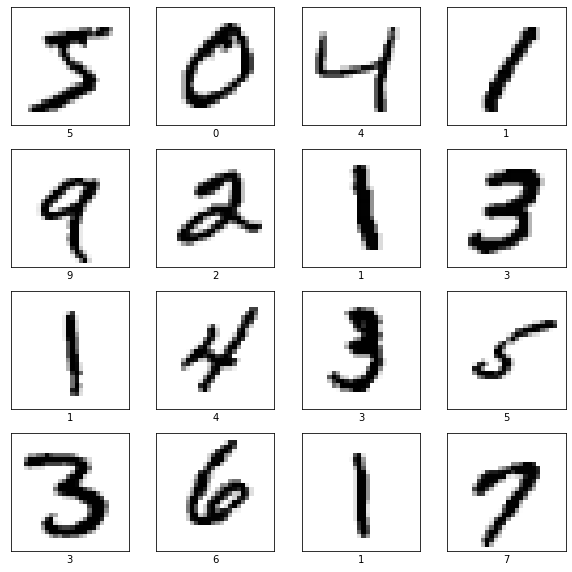

In [18]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(cases[train_labels[i]])
plt.show()

## 모델 구성
### 1. Sigmoid 모델

layer를 설정합니다. `tf.keras.layers.Dense`와 같은 층들의 가중치는 훈련하는 동안 학습됩니다.

* `tf.keras.layers.Flatten`은 2차원 28x28 픽셀의 이미지 포멧을 28*28 = 784 픽셀의 1차원 배열로 변환합니다. 이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘립니다.

* `tf.keras.layers.Dense` 층을 펼친 픽셀에 연속하여 연결합니다. 첫번째 Dense 층은 128개의 노드를 가지고, 두번째(마지막) 층은 10개 노드의 softmax 층을 가집니다. 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 각 노드는, 현재 이미지가 10개의 클래스 중 하나에 속할 확률을 출력합니다.

첫번째 모델은 sigmoid를 이용한 모델입니다.

In [38]:
model_sigmoid = keras.Sequential([
  keras.layers.Flatten(input_shape = (28,28)),
  keras.layers.Dense(128, activation = 'sigmoid'),
  keras.layers.Dense(10, activation='softmax')
])

## 모델 컴파일

* loss function - 훈련하는 동안 모델의 오차를 측정합니다.
* optimizer - 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정합니다.
* 지표 - 훈련 단계와 테스트 단계를 모니터링하기 위해 사용합니다.

In [41]:
model_sigmoid.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

## 모델 훈련

1. 훈련 데이터를 모델에 주입합니다-이 예에서는 train_images와 train_labels 배열입니다.
2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.
3. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 test_images 배열입니다. 이 예측이 test_labels 배열의 레이블과 맞는지 확인합니다.


In [44]:
model_sigmoid.fit(train_images,train_labels,epochs=90, verbose =0)

90번의 훈련 과정을 거친 뒤, 10번의 훈련 과정을 `verbose = 0` 옵션 없이 확인하여 정확도와 loss 를 확인합니다.

In [47]:
model_sigmoid.fit(train_images,train_labels,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.5980e-06 - accuracy: 1.0000
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0011 - accuracy: 0.9996
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 8.1986e-05 - accuracy: 1.0000
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.4648e-05 - accuracy: 1.0000
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 7.1141e-06 - accuracy: 1.0000
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 4.1922e-06 - accuracy: 1.0000
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 3.0121e-06 - accuracy: 1.0000
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.2172e-06 - accuracy: 1.0000
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.7647e-06 - accuracy: 1.0000
Epoch 10/10
1875/1875 [===========================

In [48]:
test_loss, test_acc = model_sigmoid.evaluate(test_images,  test_labels, verbose=2)

print('\n테스트 정확도:', test_acc)

313/313 - 0s - loss: 0.1737 - accuracy: 0.9745

테스트 정확도: 0.9745000004768372


100번의 트레이닝 결과, 테스트 셋에 대해 **97.45%**의 정확도를 가지는 것을 확인할 수 있습니다.

## 모델 구성
### 2. relu 모델

과정은 sigmoid 모델과 동일하므로 설명은 생략합니다.

In [49]:
model_relu = keras.Sequential([
  keras.layers.Flatten(input_shape = (28,28)),
  keras.layers.Dense(128, activation = 'relu'),
  keras.layers.Dense(10, activation='softmax')
])

In [50]:
model_relu.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [51]:
model_relu.fit(train_images,train_labels,epochs=90, verbose = 0)

In [52]:
model_relu.fit(train_images,train_labels,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0024 - accuracy: 0.9994
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0016 - accuracy: 0.9996
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0020 - accuracy: 0.9994
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0029 - accuracy: 0.9991
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0014 - accuracy: 0.9995
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0027 - accuracy: 0.9993
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 4.5034e-04 - accuracy: 0.9998
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 4.6611e-04 - accuracy: 0.9998
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - los

In [54]:
test_loss, test_acc = model_relu.evaluate(test_images,  test_labels, verbose=2)

print('\n테스트 정확도:', test_acc)

313/313 - 0s - loss: 0.2357 - accuracy: 0.9804

테스트 정확도: 0.980400025844574


100번의 트레이닝 결과, 테스트 셋에 대해 **98.04%**의 정확도를 가지는 것을 확인할 수 있습니다.

## 모델 구성
### 3. MSE 모델

CEE 모델은 위의 2번째 모델인 `relu` 모델을 사용합니다. 따라서 MSE 모델 또한 activation function으로는 `relu`를 사용합니다.

In [55]:
model_mse = keras.Sequential([
  keras.layers.Flatten(input_shape = (28,28)),
  keras.layers.Dense(128, activation = 'relu'),
  keras.layers.Dense(10, activation='softmax')
])

In [56]:
model_mse.compile(optimizer = 'adam', loss='mean_squared_error',metrics=['accuracy'])

In [57]:
model_mse.fit(train_images,train_labels,epochs=90,verbose = 0)

In [58]:
model_mse.fit(train_images,train_labels,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 27.3046 - accuracy: 0.0985
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 27.3046 - accuracy: 0.1006
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 27.3046 - accuracy: 0.0991
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 27.3046 - accuracy: 0.1015
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 27.3046 - accuracy: 0.1025
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 27.3045 - accuracy: 0.0992
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 27.3046 - accuracy: 0.0995
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 27.3046 - accuracy: 0.0964
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 27.3046 - accuracy: 0.0972
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - lo

In [60]:
test_loss, test_acc = model_mse.evaluate(test_images,  test_labels, verbose=2)

print('\n테스트 정확도:', test_acc)

313/313 - 0s - loss: 27.2503 - accuracy: 0.1139

테스트 정확도: 0.11389999836683273


100번의 트레이닝 결과, 테스트 셋에 대해 **11.38%**의 정확도를 가지는 것을 확인할 수 있습니다.

* sigmoid 와 relu의 테스트 정확도 비교  
sigmoid: **97.45%**, relu: **98.04%**

* mse와 cee의 테스트 정확도 비교  
mse: **11.38%**, cse: **98.04%** (<-- 무엇..?) 

## 예측 만들기

훈련된 모델들을 사용하여 이미지에 대한 예측을 만들 수 있습니다.

In [61]:
predictions_sig = model_sigmoid.predict(test_images)
predictions_relu = model_relu.predict(test_images)
predictions_mse = model_mse.predict(test_images)

In [66]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(cases[predicted_label],
                                100*np.max(predictions_array),
                                cases[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


def prediction_plot(p_type):
  num_rows = 5
  num_cols = 3
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, p_type, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, p_type, test_labels)
  plt.show()

### sigmoid 모델

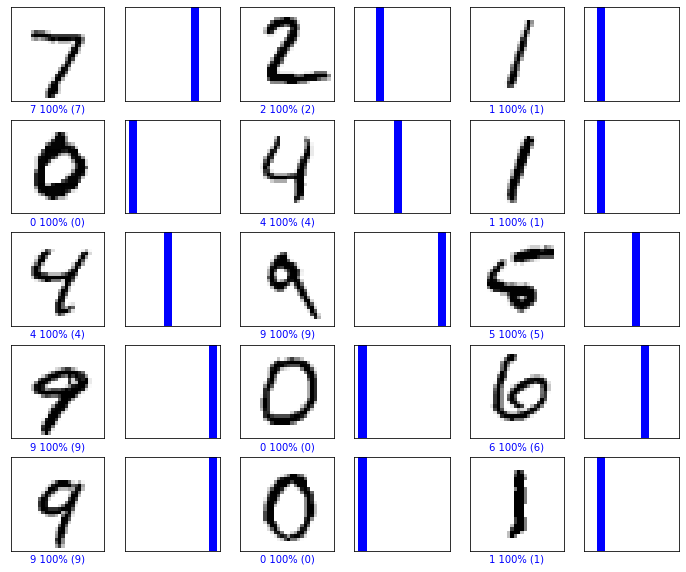

In [67]:
prediction_plot(predictions_sig)

### Relu 모델

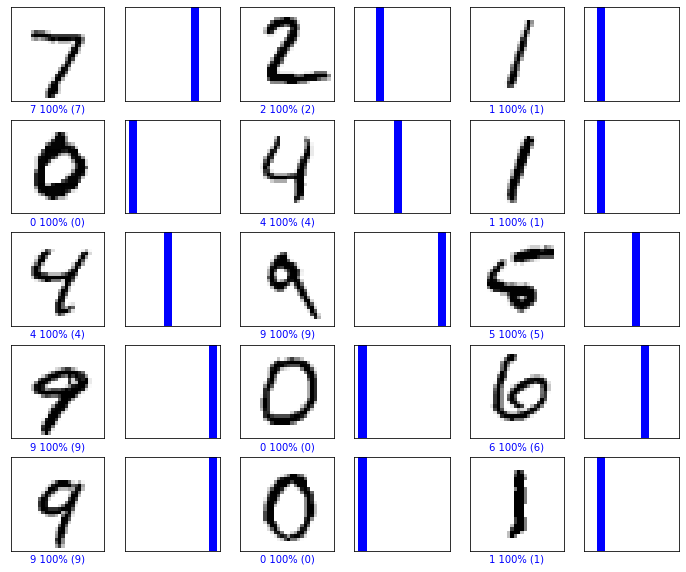

In [68]:
prediction_plot(predictions_relu)

### MSE 모델

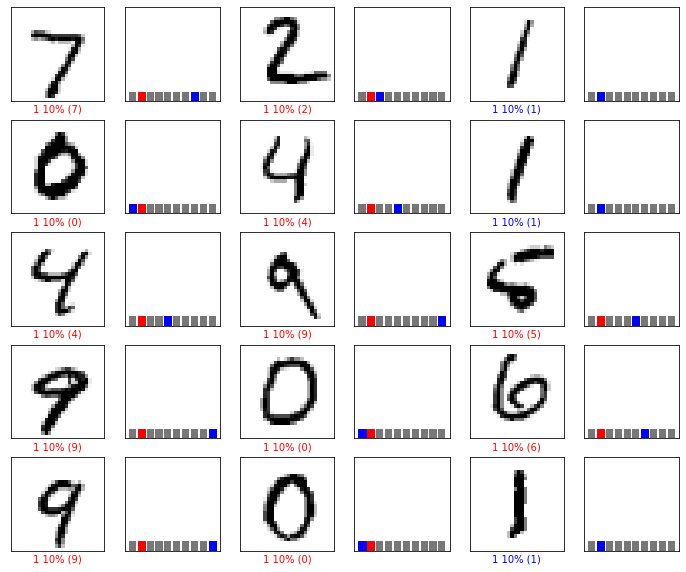

In [69]:
prediction_plot(predictions_mse)

## 결론

sigmoid와 relu를 비교해보았을 땐, relu가 1% 이상 좋은 성능을 나타내는 것을 확인할 수 있었다. 하지만 mse와 cee를 비교하였을 때, mse는 터무니없는 결과를 나타내었다.

tensorboard와 다른 이론들을 확인해가며 이유를 알게 된다면 다시 적도록 해야겠다... 아직 많이 부족하다!

[tensorboard 활용법](https://teddylee777.github.io/tensorflow/tensorboard)